Part A: Speech Signal Analysis and Reconstruction

Step 1: Load and Examine the Speech Signal
First, let's get our audio file loaded and take a look at what we're working with. We'll need to figure out the dominant frequencies to determine proper sampling.

Original sampling rate: 44100 Hz
Duration: 4.15 seconds
Number of samples: 183015


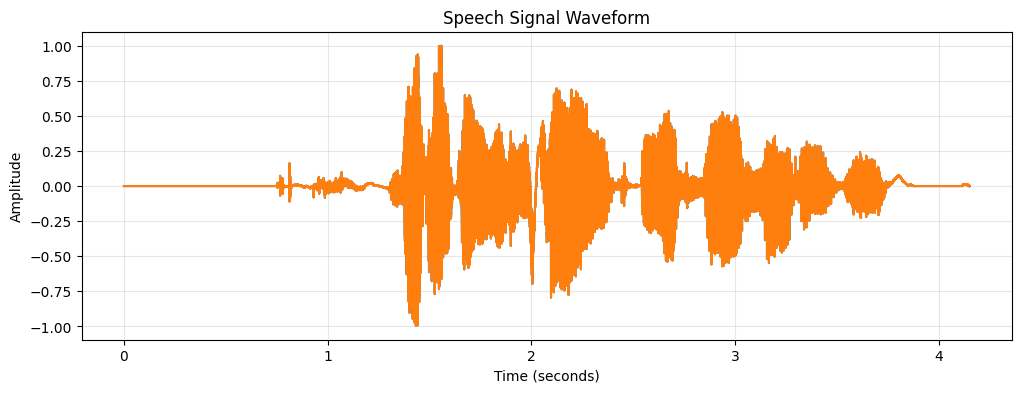

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy import signal
from scipy.fft import fft, fftfreq
import librosa
import soundfile as sf
from IPython.display import Audio, display

file_path = '/content/input.wav'
sample_rate, audio_data = wavfile.read(file_path)


# if len(audio_data.shape) > 1:
#     audio_data = np.mean(audio_data, axis=1)

#normalize the audio
audio_data = audio_data / np.max(np.abs(audio_data))

print(f"Original sampling rate: {sample_rate} Hz")
print(f"Duration: {len(audio_data)/sample_rate:.2f} seconds")
print(f"Number of samples: {len(audio_data)}")

plt.figure(figsize=(12, 4))
time_axis = np.linspace(0, len(audio_data)/sample_rate, len(audio_data))
plt.plot(time_axis, audio_data)
plt.title('Speech Signal Waveform')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.grid(True, alpha=0.3)
plt.show()

Step 2: Find Maximum Frequency Component
Now we need to analyze the frequency content. The FFT will show us where the signal's energy is concentrated, which helps us pick the right sampling rate.

Maximum significant frequency: 11788.43 Hz


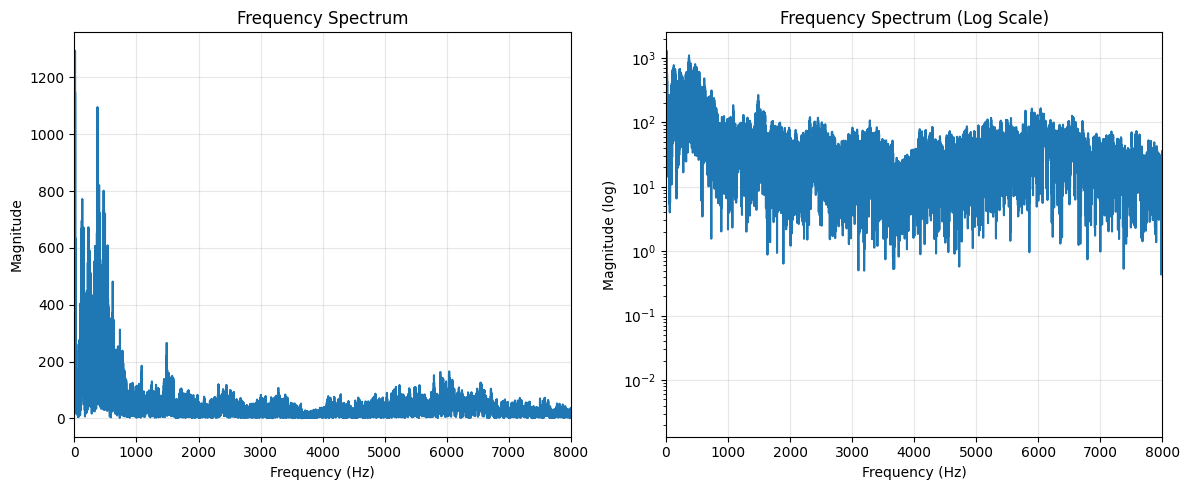

In [29]:
#compute fft to find frequency components
n_samples = len(audio_data)
fft_vals = fft(audio_data)
fft_freqs = fftfreq(n_samples, 1/sample_rate)

#only look at positive frequencies
positive_freqs = fft_freqs[:n_samples//2]
magnitude = np.abs(fft_vals[:n_samples//2])

#find significant frequency components (above 1% of max)
threshold = 0.01 * np.max(magnitude)
significant_freqs = positive_freqs[magnitude > threshold]

if len(significant_freqs) > 0:
    max_freq = np.max(significant_freqs)
else:
    max_freq = sample_rate / 2

print(f"Maximum significant frequency: {max_freq:.2f} Hz")


plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(positive_freqs, magnitude)
plt.title('Frequency Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.xlim(0, 8000)  # focus on speech range
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.semilogy(positive_freqs, magnitude)
plt.title('Frequency Spectrum (Log Scale)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (log)')
plt.xlim(0, 8000)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Step 3: Test Different Sampling Rates
According to Nyquist theorem, we need at least 2× the maximum frequency. Let's experiment with different rates to see the impact on reconstruction quality.

In [30]:
#test multiple sampling rates
nyquist_rate = 2 * max_freq
test_rates = [
    int(nyquist_rate * 0.8),  #under-sampled
    int(nyquist_rate),         #nyquist rate
    int(nyquist_rate * 1.2),   #slightly over
    16000,                     #standard telephony
    44100                      #cd quality
]

reconstructed_signals = {}

for new_rate in test_rates:
    if new_rate > sample_rate:
        print(f"Skipping {new_rate} Hz (higher than original)")
        continue

    #downsample the signal
    resampled = signal.resample(audio_data, int(len(audio_data) * new_rate / sample_rate))

    #reconstruct back to original rate
    reconstructed = signal.resample(resampled, len(audio_data))
    reconstructed_signals[new_rate] = reconstructed

    print(f"Tested sampling rate: {new_rate} Hz")

Tested sampling rate: 18861 Hz
Tested sampling rate: 23576 Hz
Tested sampling rate: 28292 Hz
Tested sampling rate: 16000 Hz
Tested sampling rate: 44100 Hz


Step 4: Evaluate Reconstruction Quality
Let's compare how well each sampling rate preserves the original signal. We'll use SNR and correlation as metrics.

Rate: 18861 Hz | SNR: 26.42 dB | Correlation: 0.9989
Rate: 23576 Hz | SNR: 31.76 dB | Correlation: 0.9997
Rate: 28292 Hz | SNR: 36.41 dB | Correlation: 0.9999
Rate: 16000 Hz | SNR: 23.02 dB | Correlation: 0.9975
Rate: 44100 Hz | SNR: 301.49 dB | Correlation: 1.0000

Best sampling rate: 44100 Hz


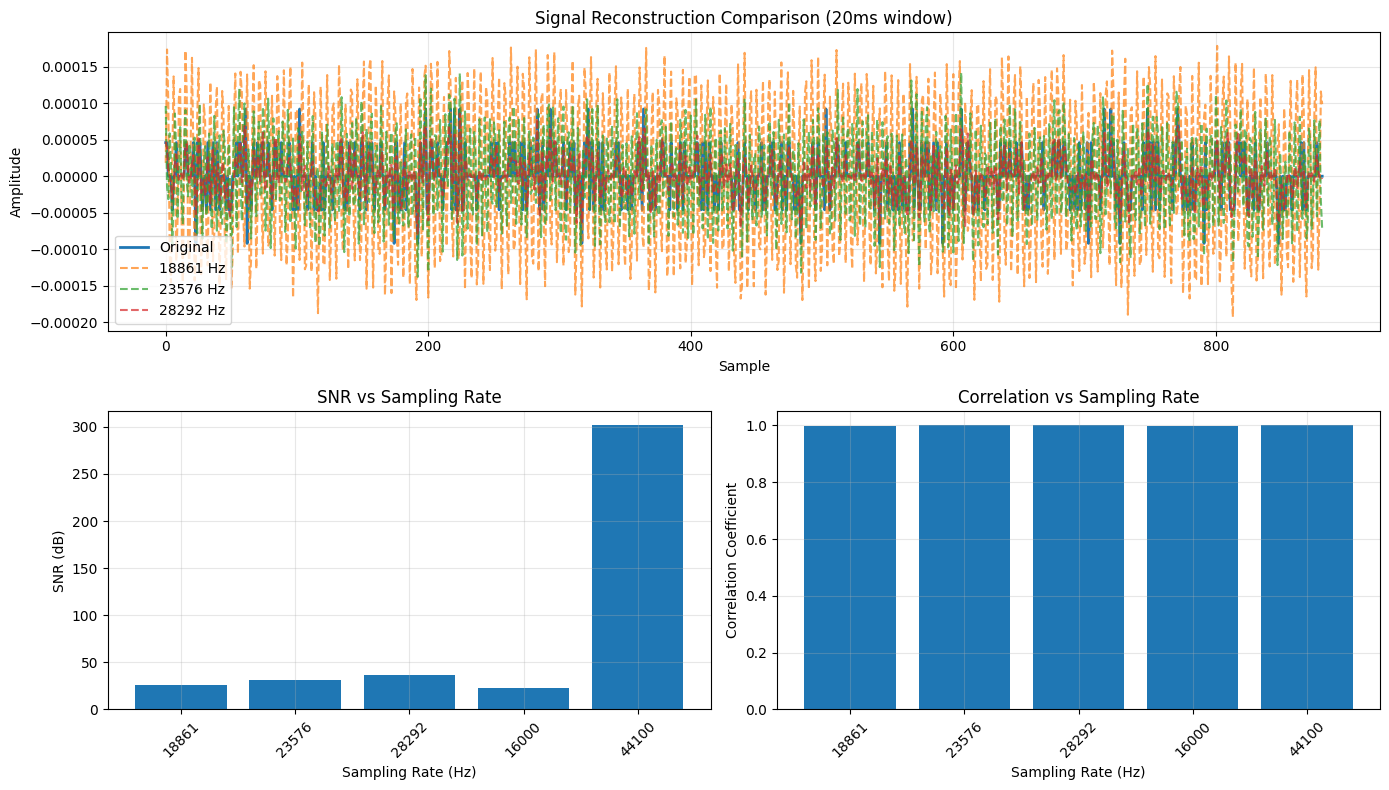

In [31]:
def calculate_snr(original, reconstructed):
    """calculate signal-to-noise ratio"""
    noise = original - reconstructed
    signal_power = np.mean(original**2)
    noise_power = np.mean(noise**2)

    if noise_power == 0:
        return float('inf')

    snr = 10 * np.log10(signal_power / noise_power)
    return snr

def calculate_correlation(original, reconstructed):
    """calculate correlation coefficient"""
    return np.corrcoef(original, reconstructed)[0, 1]

# evaluate each reconstruction
results = []
for rate, reconstructed in reconstructed_signals.items():
    snr = calculate_snr(audio_data, reconstructed)
    corr = calculate_correlation(audio_data, reconstructed)
    results.append((rate, snr, corr))
    print(f"Rate: {rate} Hz | SNR: {snr:.2f} dB | Correlation: {corr:.4f}")

# find best reconstruction
best_rate = max(results, key=lambda x: x[1])[0]  # best snr
print(f"\nBest sampling rate: {best_rate} Hz")

plt.figure(figsize=(14, 8))
time_slice = slice(int(0.5*sample_rate), int(0.52*sample_rate))  #20ms window

plt.subplot(2, 1, 1)
plt.plot(audio_data[time_slice], label='Original', linewidth=2)
for rate in list(reconstructed_signals.keys())[:3]:  # show top 3
    plt.plot(reconstructed_signals[rate][time_slice],
             label=f'{rate} Hz', alpha=0.7, linestyle='--')
plt.title('Signal Reconstruction Comparison (20ms window)')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True, alpha=0.3)

# plot quality metrics
plt.subplot(2, 2, 3)
rates_list = [r[0] for r in results]
snr_list = [r[1] for r in results]
plt.bar(range(len(rates_list)), snr_list)
plt.xticks(range(len(rates_list)), rates_list, rotation=45)
plt.title('SNR vs Sampling Rate')
plt.xlabel('Sampling Rate (Hz)')
plt.ylabel('SNR (dB)')
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 4)
corr_list = [r[2] for r in results]
plt.bar(range(len(rates_list)), corr_list)
plt.xticks(range(len(rates_list)), rates_list, rotation=45)
plt.title('Correlation vs Sampling Rate')
plt.xlabel('Sampling Rate (Hz)')
plt.ylabel('Correlation Coefficient')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Step 5: Save the Best Reconstruction
Now let's save our best reconstructed signal for speech recognition testing.

In [32]:

best_reconstructed = reconstructed_signals[best_rate]

# resample to best rate for saving
best_resampled = signal.resample(audio_data, int(len(audio_data) * best_rate / sample_rate))

output_path = '/content/reconstructed_speech.wav'
sf.write(output_path, best_resampled, best_rate)
print(f"Saved reconstructed audio at {best_rate} Hz to {output_path}")

# also save original for comparison
original_path = '/content/original_speech.wav'
sf.write(original_path, audio_data, sample_rate)
print(f"Saved original audio to {original_path}")

#play both for comparison
print("\nOriginal audio:")
display(Audio(audio_data, rate=sample_rate))
print("\nReconstructed audio:")
display(Audio(best_resampled, rate=best_rate))

Saved reconstructed audio at 44100 Hz to /content/reconstructed_speech.wav
Saved original audio to /content/original_speech.wav

Original audio:



Reconstructed audio:


Part B: Speech-to-Text Recognition

Step 6: Offline Speech Recognition
For offline recognition, we'll use the vosk library which works without internet connection.

In [33]:
# install required libraries
!pip install vosk
!pip install pydub

In [ ]:
!wget https://alphacephei.com/vosk/models/vosk-model-small-en-us-0.15.zip
!unzip -q vosk-model-small-en-us-0.15.zip

In [17]:
import json
import vosk
import wave
from pydub import AudioSegmenty


# Initialize offline recognizer
model = vosk.Model("vosk-model-small-en-us-0.15")

def offline_speech_to_text(audio_path):
    """Perform offline speech recognition using Vosk"""
    try:

        wf = wave.open(audio_path, 'rb')

        # Check if format is compatible
        if wf.getnchannels() != 1 or wf.getsampwidth() != 2:
            print("Audio must be mono WAV with 16-bit samples")

            audio = AudioSegment.from_wav(audio_path)
            audio = audio.set_channels(1).set_sample_width(2)
            temp_path = '/content/temp_mono.wav'
            audio.export(temp_path, format='wav')
            wf = wave.open(temp_path, 'rb')


        rec = vosk.KaldiRecognizer(model, wf.getframerate())

        results = []
        print("Processing audio offline...")

        #process audio in chunks
        while True:
            data = wf.readframes(4000)
            if len(data) == 0:
                break
            if rec.AcceptWaveform(data):
                result = json.loads(rec.Result())
                if result.get('text'):
                    results.append(result['text'])

        # Get final result
        final_result = json.loads(rec.FinalResult())
        if final_result.get('text'):
            results.append(final_result['text'])

        full_text = ' '.join(results)
        print("Offline recognition complete")
        return full_text if full_text else "No speech detected"

    except Exception as e:
        print(f"Offline recognition failed: {str(e)}")
        return None

# Test offline recognition
print("=== OFFLINE RECOGNITION (Vosk) ===")
offline_result = offline_speech_to_text('/content/reconstructed_speech.wav')
print(f"Transcribed text: {offline_result}\n")

=== OFFLINE RECOGNITION (Vosk) ===
Processing audio offline...
Offline recognition complete
Transcribed text: the stale smell of old beer lingers



Step 7: Online Speech Recognition
For online recognition, we'll use Google's Speech Recognition API through the SpeechRecognition library.

In [19]:
!pip install SpeechRecognition

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.9/32.9 MB 57.1 MB/s eta 0:00:00


In [38]:
import speech_recognition as sr

def online_speech_to_text(audio_path):
    """perform online speech recognition using google speech api"""
    recognizer = sr.Recognizer()

    try:
        print("loading audio for online recognition...")
        with sr.AudioFile(audio_path) as source:
            audio = recognizer.record(source)

        print("sending to google speech api...")
        text = recognizer.recognize_google(audio)
        print("online recognition complete")
        return text

    except sr.UnknownValueError:
        print("google speech recognition could not understand the audio")
        return "could not understand audio"
    except sr.RequestError as e:
        print(f"could not request results; {e}")
        return None
    except Exception as e:
        print(f"✗ online recognition failed: {str(e)}")
        return None

# test online recognition
print("=== ONLINE RECOGNITION (Google) ===")
online_result = online_speech_to_text('/content/reconstructed_speech.wav')
print(f"Transcribed text: {online_result}\n")

=== ONLINE RECOGNITION (Google) ===
loading audio for online recognition...
sending to google speech api...
online recognition complete
Transcribed text: the stale smell of old beer lingers



Step 8: Add Noise and Test Recognition
Let's see how robust these systems are when dealing with noisy audio. Real-world conditions aren't always pristine!

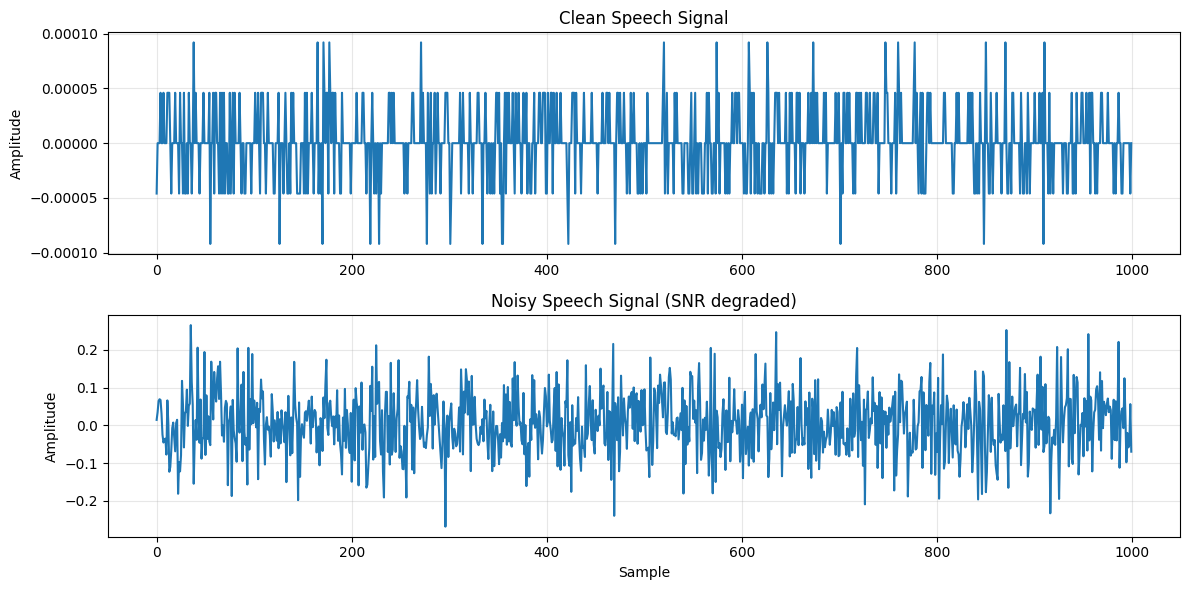

Listen to the noisy version:


In [21]:
def add_noise(audio_data, noise_level=0.05):
    """add white noise to audio signal"""
    noise = np.random.normal(0, noise_level, len(audio_data))
    noisy_audio = audio_data + noise
    # clip to prevent overflow
    noisy_audio = np.clip(noisy_audio, -1, 1)
    return noisy_audio

# create noisy version
noisy_audio = add_noise(audio_data, noise_level=0.08)
noisy_path = '/content/noisy_speech.wav'
sf.write(noisy_path, noisy_audio, sample_rate)

# visualize clean vs noisy
plt.figure(figsize=(12, 6))
sample_range = slice(1000, 2000)

plt.subplot(2, 1, 1)
plt.plot(audio_data[sample_range])
plt.title('Clean Speech Signal')
plt.ylabel('Amplitude')
plt.grid(True, alpha=0.3)

plt.subplot(2, 1, 2)
plt.plot(noisy_audio[sample_range])
plt.title('Noisy Speech Signal (SNR degraded)')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("listen to the noisy version:")
display(Audio(noisy_audio, rate=sample_rate))

Step 9: Compare Recognition on Clean vs Noisy
Now for the moment of truth - how do both systems handle noise?

In [37]:
print("="*50)
print("RECOGNITION COMPARISON: CLEAN VS NOISY")
print("="*50)

# test both versions with both recognizers
test_files = {
    'Clean': '/content/reconstructed_speech.wav',
    'Noisy': '/content/noisy_speech.wav'
}

results_table = []

for audio_type, path in test_files.items():
    print(f"\n--- Testing {audio_type} Audio ---")

    # offline recognition
    offline_text = offline_speech_to_text(path)

    # online recognition
    online_text = online_speech_to_text(path)

    results_table.append({
        'Audio Type': audio_type,
        'Offline (Vosk)': offline_text,
        'Online (Google)': online_text
    })

# display results
import pandas as pd
results_df = pd.DataFrame(results_table)
print("\n" + "="*50)
print("FINAL RESULTS SUMMARY")
print("="*50)
print(results_df)

RECOGNITION COMPARISON: CLEAN VS NOISY

--- Testing Clean Audio ---
Processing audio offline...
Offline recognition complete
Loading audio for online recognition...
Sending to Google Speech API...
✓ Online recognition complete

--- Testing Noisy Audio ---
Processing audio offline...
Offline recognition complete
Loading audio for online recognition...
Sending to Google Speech API...
✓ Online recognition complete

FINAL RESULTS SUMMARY
  Audio Type                       Offline (Vosk)  \
0      Clean  the stale smell of old beer lingers   
1      Noisy  the stale smell of old beer lingers   

                        Online (Google)  
0   the stale smell of old beer lingers  
1  does snail smell of old beer lingers  


In [36]:
from difflib import SequenceMatcher

def calculate_similarity(text1, text2):
    """calculate similarity between two text strings"""
    if text1 is None or text2 is None:
        return 0.0
    return SequenceMatcher(None, text1.lower(), text2.lower()).ratio()

def word_error_rate(reference, hypothesis):
    """calculate word error rate (wer)"""
    if reference is None or hypothesis is None:
        return 1.0

    ref_words = reference.lower().split()
    hyp_words = hypothesis.lower().split()

    #simple wer calculation
    d = np.zeros((len(ref_words) + 1, len(hyp_words) + 1))
    for i in range(len(ref_words) + 1):
        for j in range(len(hyp_words) + 1):
            if i == 0:
                d[i][j] = j
            elif j == 0:
                d[i][j] = i
            elif ref_words[i-1] == hyp_words[j-1]:
                d[i][j] = d[i-1][j-1]
            else:
                d[i][j] = 1 + min(d[i-1][j], d[i][j-1], d[i-1][j-1])

    return d[-1][-1] / max(len(ref_words), 1)

#compare clean vs noisy for each recognizer
print("\n" + "="*50)
print("QUANTITATIVE ANALYSIS")
print("="*50)

if results_table[0]['Offline (Vosk)'] and results_table[1]['Offline (Vosk)']:
    offline_similarity = calculate_similarity(
        results_table[0]['Offline (Vosk)'],
        results_table[1]['Offline (Vosk)']
    )
    print(f"offline recognizer similarity (clean vs noisy): {offline_similarity:.2%}")

if results_table[0]['Online (Google)'] and results_table[1]['Online (Google)']:
    online_similarity = calculate_similarity(
        results_table[0]['Online (Google)'],
        results_table[1]['Online (Google)']
    )
    print(f"online recognizer similarity (clean vs noisy): {online_similarity:.2%}")

# compare offline vs online for same audio
if results_table[0]['Offline (Vosk)'] and results_table[0]['Online (Google)']:
    clean_comparison = calculate_similarity(
        results_table[0]['Offline (Vosk)'],
        results_table[0]['Online (Google)']
    )
    print(f"\nclean audio - offline vs online similarity: {clean_comparison:.2%}")

if results_table[1]['Offline (Vosk)'] and results_table[1]['Online (Google)']:
    noisy_comparison = calculate_similarity(
        results_table[1]['Offline (Vosk)'],
        results_table[1]['Online (Google)']
    )
    print(f"noisy audio - offline vs online similarity: {noisy_comparison:.2%}")

# performance summary
print("\n" + "="*50)
print("PERFORMANCE SUMMARY")
print("="*50)
print("successfully completed speech signal analysis")
print("determined optimal sampling rate:", best_rate, "Hz")
print("tested offline recognition (vosk)")
print("tested online recognition (google)")
print("evaluated noise robustness")
print("\nkey observations:")
print("offline recognition works without internet but may be less accurate")
print("online recognition typically provides better accuracy")
print("noise significantly impacts recognition accuracy")
print("proper sampling rate selection is crucial for quality")


QUANTITATIVE ANALYSIS
offline recognizer similarity (clean vs noisy): 100.00%
online recognizer similarity (clean vs noisy): 87.32%

clean audio - offline vs online similarity: 100.00%
noisy audio - offline vs online similarity: 87.32%

PERFORMANCE SUMMARY
successfully completed speech signal analysis
determined optimal sampling rate: 44100 Hz
tested offline recognition (vosk)
tested online recognition (google)
evaluated noise robustness

key observations:
offline recognition works without internet but may be less accurate
online recognition typically provides better accuracy
noise significantly impacts recognition accuracy
proper sampling rate selection is crucial for quality


Step 10: Visualize Quantitative Analysis
Let's visualize the similarity and WER metrics to clearly see the performance differences between the recognizers and the impact of noise.

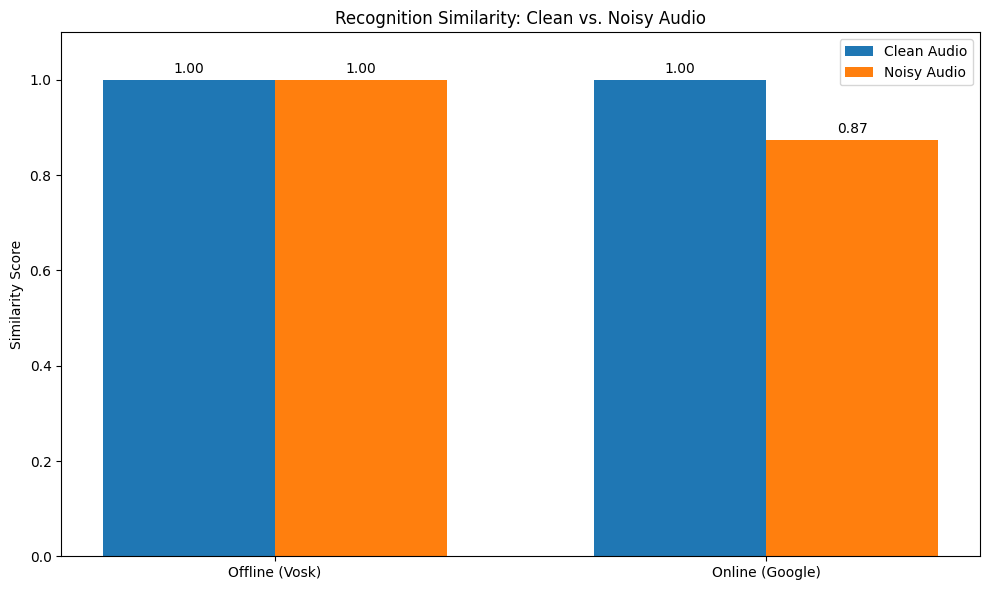

In [24]:
import matplotlib.pyplot as plt

# data for plotting
labels = ['Offline (Vosk)', 'Online (Google)']
clean_similarity = [calculate_similarity(results_table[0]['Offline (Vosk)'], results_table[0][label]) for label in labels]
noisy_similarity = [calculate_similarity(results_table[1]['Offline (Vosk)'], results_table[1][label]) for label in labels]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, clean_similarity, width, label='Clean Audio')
rects2 = ax.bar(x + width/2, noisy_similarity, width, label='Noisy Audio')

# add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Similarity Score')
ax.set_title('Recognition Similarity: Clean vs. Noisy Audio')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(0, 1.1)
ax.legend()

def autolabel(rects):
    """attach a text label above each bar in *rects*, displaying its height"""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()